# **Predicting Disaster Tweets Using LSTM**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import re
text_cleaning_regex = "@S+|https?:S+|http?:S|[^A-Za-z0-9]+"

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import nltk
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

import tensorflow as tf
import keras

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics


from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
from tensorflow.keras.preprocessing.sequence import pad_sequences



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Download Data

In [2]:
!mkdir Dataset
%cd  Dataset

mkdir: cannot create directory ‘Dataset’: File exists
/content/Dataset


In [3]:
!wget https://github.com/Laterma/Predicting-Disaster-Tweets-Using-LSTM/raw/main/Data.zip

--2022-02-07 02:03:44--  https://github.com/Laterma/Predicting-Disaster-Tweets-Using-LSTM/raw/main/Data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Laterma/Predicting-Disaster-Tweets-Using-LSTM/main/Data.zip [following]
--2022-02-07 02:03:44--  https://raw.githubusercontent.com/Laterma/Predicting-Disaster-Tweets-Using-LSTM/main/Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 601081 (587K) [application/zip]
Saving to: ‘Data.zip.4’

Data.zip.4          100%[===================>] 586.99K  --.-KB/s    in 0.04s   

2022-02-07 02:03:45 (13.2 MB/s) - ‘Data.zip.4’ saved [601081/601081]


In [4]:
!unzip Data.zip

Archive:  Data.zip
replace columns Description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Reading Data

In [5]:
df_train = pd.read_csv('/content/Dataset/train.csv')

In [6]:
df_test = pd.read_csv('/content/Dataset/test.csv')

# Exploring The Data

In [7]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      df_train.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [10]:
print(f" The percentage of missing data in columns is: \n\n",
      df_train.isnull().sum()/len(df_train)*100)

 The percentage of missing data in columns is: 

 id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


In [11]:
for i in list(df_train):
    # show the list of values  
    print(f"The Unique values of column {i} is {df_train[i].nunique()}")

The Unique values of column id is 7613
The Unique values of column keyword is 221
The Unique values of column location is 3341
The Unique values of column text is 7503
The Unique values of column target is 2


In [12]:
df_train['location'].value_counts()[:15]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
Name: location, dtype: int64

In [13]:
df_train['keyword'].value_counts()[:15]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
Name: keyword, dtype: int64

#The most common stop/non-stop words

In [31]:
text_list = []
stop_words_list = []
nonstop_words_list = []

def rm_uni_code(text):
    text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
    return text

df_train['temp_column'] = df_train['text']

In [32]:
df_train['temp_column']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: temp_column, Length: 7613, dtype: object

In [33]:
df_train['temp_column'] = df_train['text'].apply(lambda x: rm_uni_code(x) )


In [34]:
df_train['temp_column']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13 000 people receive wildfires evacuation ord...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609     aria ahrary thetawniest the out of control wi...
7610    m1 94 01 04 utc 5km s of volcano hawaii http t...
7611    police investigating after an e bike collided ...
7612    the latest more homes razed by northern califo...
Name: temp_column, Length: 7613, dtype: object

In [35]:
text_list = " ".join(df_train["temp_column"]).split()
for x in text_list:
  if x in stop_words:
    stop_words_list.append(x)
  else:
    nonstop_words_list.append(x)

#The 6 most common non-stop words

In [43]:
Counter(nonstop_words_list).most_common(6)

[('co', 4740),
 ('http', 4309),
 ('https', 412),
 ('like', 348),
 ('amp', 344),
 ('fire', 254)]

#The 6 most common stop words

In [44]:
Counter(stop_words_list).most_common(6)

[('t', 5231),
 ('the', 3284),
 ('a', 2209),
 ('in', 1989),
 ('to', 1949),
 ('of', 1830)]

#Preparing Data

In [14]:
df_train = df_train.drop(['location', 'keyword', 'id', 'temp_column'], axis=1)
df_train.head(10)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


In [15]:
df_test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [16]:
df_test.drop(['location', 'keyword', 'id'], axis=1)
df_test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [18]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

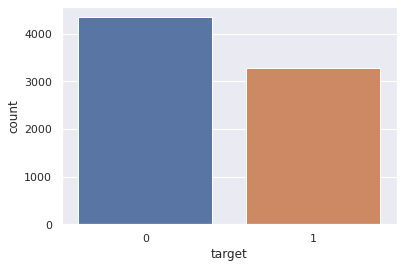

In [19]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="target", data=df_train)

In [20]:
for col in df_train.columns:
  print(f"The number of nan values in {col} is: {df_train[col].isna().sum()}")

The number of nan values in text is: 0
The number of nan values in target is: 0


In [21]:
df_train['cleaned_text']= df_train['text']

In [22]:
df_train[['text', 'cleaned_text']]

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...
...,...,...
7608,Two giant cranes holding a bridge collapse int...,Two giant cranes holding a bridge collapse int...
7609,@aria_ahrary @TheTawniest The out of control w...,@aria_ahrary @TheTawniest The out of control w...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,Police investigating after an e-bike collided ...,Police investigating after an e-bike collided ...


In [23]:
def clean_tweets(tweet):
  
  #remove uni-code characters and lower case the tweets
  tweet = re.sub(text_cleaning_regex, ' ', str(tweet).lower()).strip()

  # remove numbers from text
  tweet = re.sub(r'\d+', '', tweet)

  #stemming
  tweet = stemmer.stem(tweet)

  #remove stop words
  stop = stopwords.words('english')
  tweet = " ".join([word for word in tweet.split() if word not in (stop)])

  #apply tokenization
  tweet = re.split('\W+',tweet)

  # return " ".join(" ".join(tweet).split())
  return tweet

df_train['cleaned_text'] = df_train['text'].apply(lambda x: clean_tweets(x) )



In [24]:
df_train[['text', 'cleaned_text']]

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,"[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...","[people, receive, wildfires, evacuation, order..."
4,Just got sent this photo from Ruby #Alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...
7608,Two giant cranes holding a bridge collapse int...,"[two, giant, cranes, holding, bridge, collapse..."
7609,@aria_ahrary @TheTawniest The out of control w...,"[aria, ahrary, thetawniest, control, wild, fir..."
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,"[utc, km, volcano, hawaii, http, co, zdtoydebj]"
7611,Police investigating after an e-bike collided ...,"[police, investigating, e, bike, collided, car..."


In [25]:
# train and test splitting
X_train, X_test,y_train, y_test = model_selection.train_test_split(df_train['cleaned_text'],
                                                                   df_train['target'],
                                                                   test_size=0.2,
                                                                   random_state=0, 
                                                                   shuffle=True)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 6090
Test Data size 1523


# Pre-Building the model

In [ ]:
X_train

1386    [ted, cruz, fires, back, jeb, amp, bush, lose,...
4048    [first, year, forest, service, spent, half, an...
3086    [lightseraphs, pissed, could, pikachu, electro...
272                     [gonna, fight, taylor, soon, get]
7462    [nicolaclements, sure, covering, head, wounds,...
                              ...                        
4931    [real, heroes, rip, brave, hearts, http, co, q...
3264    [car, engulfed, flames, backs, traffic, parley...
1653    [great, british, bake, back, dorret, chocolate...
2607    [black, eye, space, battle, occurred, star, in...
2732    [mikeparractor, absolutely, devastated, actor,...
Name: cleaned_text, Length: 6090, dtype: object

In [ ]:
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(word_index)

{'co': 1, 'http': 2, 'https': 3, 'amp': 4, 'like': 5, 'new': 6, 'fire': 7, 'get': 8, 'via': 9, 'one': 10, 'people': 11, 'news': 12, 'emergency': 13, 'video': 14, 'u': 15, 'disaster': 16, 'would': 17, 'police': 18, 'still': 19, 'us': 20, 'california': 21, 'crash': 22, 'back': 23, 'burning': 24, 'body': 25, 'day': 26, 'got': 27, 'first': 28, 'suicide': 29, 'storm': 30, 'know': 31, 'rt': 32, 'time': 33, 'man': 34, 'today': 35, 'dead': 36, 'going': 37, 'killed': 38, 'pm': 39, 'bomb': 40, 'year': 41, 'world': 42, 'attack': 43, 'buildings': 44, 'w': 45, 'nuclear': 46, 'go': 47, 'families': 48, 'see': 49, 'car': 50, 'fires': 51, 'full': 52, 'war': 53, 'two': 54, 'train': 55, 'hiroshima': 56, 'may': 57, 'gt': 58, 'good': 59, 'think': 60, 'love': 61, 'say': 62, 'old': 63, 'best': 64, 'let': 65, 'mass': 66, 'life': 67, 'watch': 68, 'way': 69, 'many': 70, 'could': 71, 'mh': 72, 'accident': 73, 'death': 74, 'help': 75, 'last': 76, 'work': 77, 'another': 78, 'look': 79, 'bombing': 80, 'right': 81, 

In [ ]:
vocab_size = len(word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 18073


In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),maxlen = 30)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen = 30)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-02-06 02:44:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-06 02:44:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-06 02:44:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embeddings_index = {}
# opening the downloaded glove embeddings file
f = open('glove.6B.300d.txt')
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

#Model Architecture

In [ ]:
# The Input layer 
sequence_input = Input(shape=(30,), dtype='int32')
# Inputs passed to the embedding layer
embedding_sequences = embedding_layer(sequence_input)
# dropout and conv layer 
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
# Passed on to the LSTM layer
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
# Passed on to activation layer to get final output
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           5421900   
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)

In [ ]:
training = model.fit(X_train, y_train, batch_size=1024, epochs=20,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/20
6/6 [==============================] - 20s 690ms/step - loss: 1.0169 - accuracy: 0.5466 - val_loss: 0.6153 - val_accuracy: 0.6382 - lr: 0.0100
Epoch 2/20
6/6 [==============================] - 5s 851ms/step - loss: 0.5792 - accuracy: 0.7094 - val_loss: 0.4861 - val_accuracy: 0.7833 - lr: 0.0100
Epoch 3/20
6/6 [==============================] - 6s 1s/step - loss: 0.4741 - accuracy: 0.7897 - val_loss: 0.4540 - val_accuracy: 0.7912 - lr: 0.0100
Epoch 4/20
6/6 [==============================] - 5s 794ms/step - loss: 0.4320 - accuracy: 0.8126 - val_loss: 0.4412 - val_accuracy: 0.8024 - lr: 0.0100
Epoch 5/20
6/6 [==============================] - 6s 947ms/step - loss: 0.4084 - accuracy: 0.8250 - val_loss: 0.4414 - val_accuracy: 0.8017 - lr: 0.0100
Epoch 6/20
6/6 [==============================] - 5s 765ms/step - loss: 0.3868 - accuracy: 0.8348 - val_loss: 0.4507 - val_accuracy: 0.7984 - lr: 0.0100
Epoch 7/20
6/6 [==============================] - 5s 859ms/step - loss: 0.3482 - acc

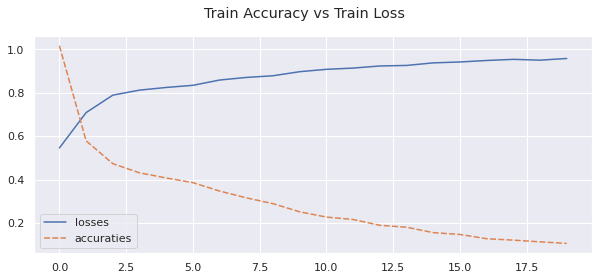

In [ ]:
# Plot train accuracy and loss
accuraties = training.history['accuracy']
losses = training.history['loss']
accuraties_losses = list(zip(accuraties,losses))

accuraties_losses_df = pd.DataFrame(accuraties_losses, columns={"accuraties", "losses"})

plt.figure(figsize=(10,4))
plt.suptitle("Train Accuracy vs Train Loss")
sns.lineplot(data=accuraties_losses_df)
plt.show()

In [ ]:
scores = model.predict(X_test, verbose=1, batch_size=10000)

1/1 [==============================] - 1s 951ms/step


In [ ]:
def predict_tweet_sentiment(score):
    return 1 if score>0.5 else 0

In [ ]:
model_predictions = [predict_tweet_sentiment(score) for score in scores]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model_predictions))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       886
           1       0.72      0.76      0.74       637

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.77      0.77      1523



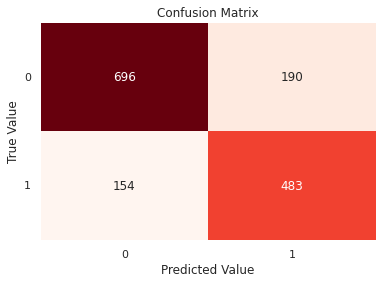

In [ ]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, model_predictions)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()

#Tuning Hyperparameteres